# Intro to Deep Learning Systems : HW 2
## Problem 1: Perceptron

In [1]:
# Imports
import numpy as np
from numpy.random import default_rng
from datetime import datetime, timedelta
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
rng = default_rng()
# Generate training data
def generate_data(n):
    x = rng.uniform(low=0.0, high=1.0, size=(n, 2))
    func = lambda x: 1 if x else -1
    y = np.vectorize(func)(x[:, 0] > x[:, 1])
    
    return x, y
X_train, y_train = generate_data(10)
print("Training Data")
np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)

Training Data


array([[ 0.34211669,  0.87744884, -1.        ],
       [ 0.97174049,  0.4609842 ,  1.        ],
       [ 0.96539179,  0.42459755,  1.        ],
       [ 0.04958916,  0.40945989, -1.        ],
       [ 0.87659326,  0.35813119,  1.        ],
       [ 0.22563068,  0.03088381,  1.        ],
       [ 0.56232169,  0.93533385, -1.        ],
       [ 0.87377645,  0.26495302,  1.        ],
       [ 0.07989474,  0.84837637, -1.        ],
       [ 0.48963091,  0.18715742,  1.        ]])

In [3]:
def train_perceptron(X_train, y_train, epoch_lim=1000, hinge_loss=False):
    """Train weights for given data via perceptron algorithm.

    Args:
        X_train: Feature matrix
        y_train: Class labels
        epoch_lim: Upper epoch limit to cut-off training
        hinge_loss: Specify whether to use hinge loss

    Returns:
        Trained weights
    """
    w = np.zeros(X_train.shape[1])
    epoch, convergence = 0, False
    threshold = 1 if hinge_loss else 0

    while not convergence and epoch < epoch_lim:
        convergence = True
        for i in range(len(X_train)):
            x = X_train[i]
            y = y_train[i]

            margin = y * np.dot(w, x)
            if margin <= threshold:
                convergence = False
                w += y * x

        epoch += 1
    
    if not convergence:
        print("Convergence not achieved. Too many epochs.")
    return w

def predict_perceptron(x, weights):
    """Predict values using perceptron weights

    Args:
        x: Input features
        weights: Perceptron weights

    Return:
        Output vector
    """

    return np.sign(np.dot(x, weights))

In [4]:
# Training
w_perceptron = train_perceptron(X_train, y_train)
w_hinge = train_perceptron(X_train, y_train, hinge_loss=True)

# Test
perceptron_accuracy, hinge_accuracy = [], []
for i in range(10):
    X_test, y_test = generate_data(5000)
    pred_perceptron = predict_perceptron(X_test, w_perceptron)
    pred_hinge = predict_perceptron(X_test, w_hinge)
    
    perceptron_accuracy.append(sum(pred_perceptron == y_test) / pred_perceptron.shape[0])
    hinge_accuracy.append(sum(pred_hinge == y_test) / pred_hinge.shape[0])

print(f"Mean accuracy with perceptron loss: {np.mean(perceptron_accuracy)}")
print(f"Mean accuracy with hinge loss: {np.mean(hinge_accuracy)}")

Convergence not achieved. Too many epochs.
Mean accuracy with perceptron loss: 0.9911999999999999
Mean accuracy with hinge loss: 0.99624


## Problem 2: Weight Initialization, Dead Neurons, Leaky ReLU

In [2]:
from deepreplay.callbacks import ReplayData
from deepreplay.replay import Replay
from deepreplay.plot import compose_plots
from keras.initializers import normal
from q2.model_builder import *

Using TensorFlow backend.
c:\users\perfe\pycharmprojects\ms-cs\courses\idls\hw2\py36_env\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\perfe\pycharmprojects\ms-cs\courses\idls\hw2\py36_env\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\perfe\pycharmprojects\ms-cs\courses\idls\hw2\py36_env\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

In [3]:
from keras.models import Sequential
from keras.layers import Dense

def build_model(n_layers, input_dim, units, activation, initializer):
    if isinstance(units, list):
        assert len(units) == n_layers
    else:
        units = [units] * n_layers
        
    model = Sequential()
    # Adds first hidden layer with input_dim parameter
    model.add(Dense(units=units[0], 
                    input_dim=input_dim, 
                    activation=activation,
                    kernel_initializer=initializer, 
                    name='h1'))
    
    # Adds remaining hidden layers
    for i in range(2, n_layers + 1):
        model.add(Dense(units=units[i-1], 
                        activation=activation, 
                        kernel_initializer=initializer, 
                        name='h{}'.format(i)))
    
    # Adds output layer
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=initializer, name='o'))
    # Compiles the model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
    return model

In [4]:
from deepreplay.datasets.ball import load_data

X, y = load_data(n_dims=10)

In [5]:
def plot_violins(std, activation):
    filename = 'part2_weight_initializers.h5'
    group_name = f'sigmoid_stdev_{std}'

    # Uses normal initializer
    initializer = normal(mean=0, stddev=std, seed=13)

    # Builds BLOCK model
    model = build_model(n_layers=5, input_dim=10, units=100, 
                        activation=activation, initializer=initializer)

    # Since we only need initial weights, we don't even need to train the model! 
    # We still use the ReplayData callback, but we can pass the model as argument instead
    replaydata = ReplayData(X, y, filename=filename, group_name=group_name, model=model)

    # Now we feed the data to the actual Replay object
    # so we can build the visualizations
    replay = Replay(replay_filename=filename, group_name=group_name)

    # Using subplot2grid to assemble a complex figure...
    fig = plt.figure(figsize=(12, 6))
    ax_zvalues = plt.subplot2grid((2, 2), (0, 0))
    ax_weights = plt.subplot2grid((2, 2), (0, 1))
    ax_activations = plt.subplot2grid((2, 2), (1, 0))
    ax_gradients = plt.subplot2grid((2, 2), (1, 1))

    wv = replay.build_weights(ax_weights)
    gv = replay.build_gradients(ax_gradients)
    # Z-values
    zv = replay.build_outputs(ax_zvalues, before_activation=True, 
                              exclude_outputs=True, include_inputs=False)
    # Activations
    av = replay.build_outputs(ax_activations, exclude_outputs=True, include_inputs=False)

    # Finally, we use compose_plots to update all
    # visualizations at once
    fig = compose_plots([zv, wv, av, gv], 
                        epoch=0, 
                        title=rf'Activation: {activation} - Initializer: Normal $\sigma = {std}$')

### Q2.1

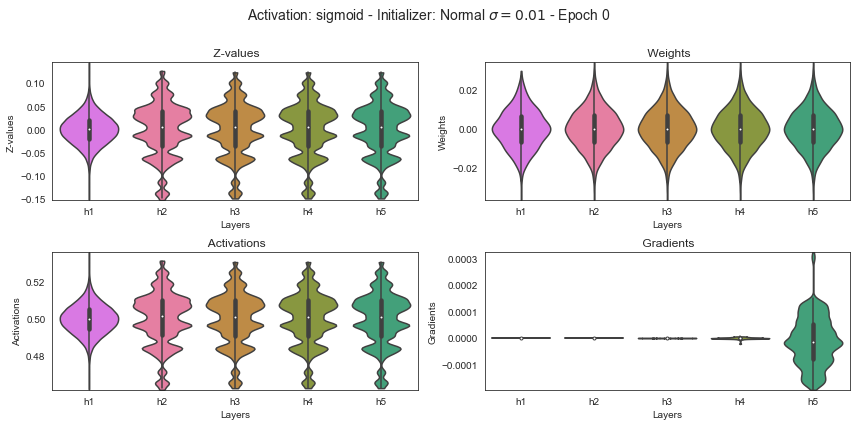

In [6]:
plot_violins(std=0.01, activation='sigmoid')

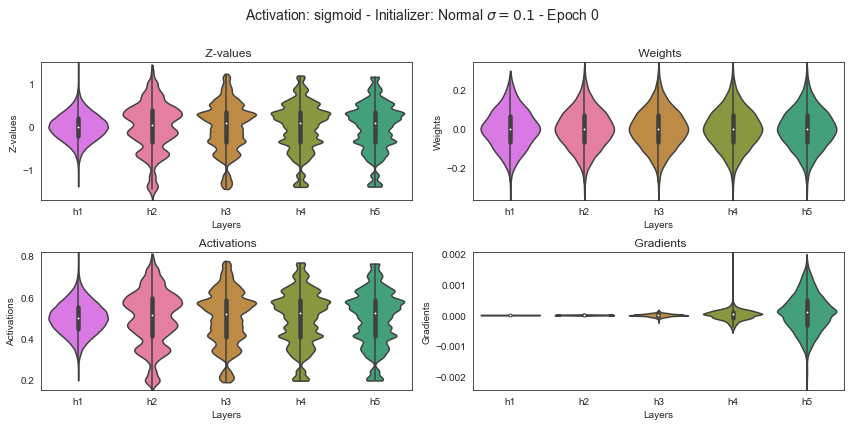

In [7]:
plot_violins(std=0.1, activation='sigmoid')

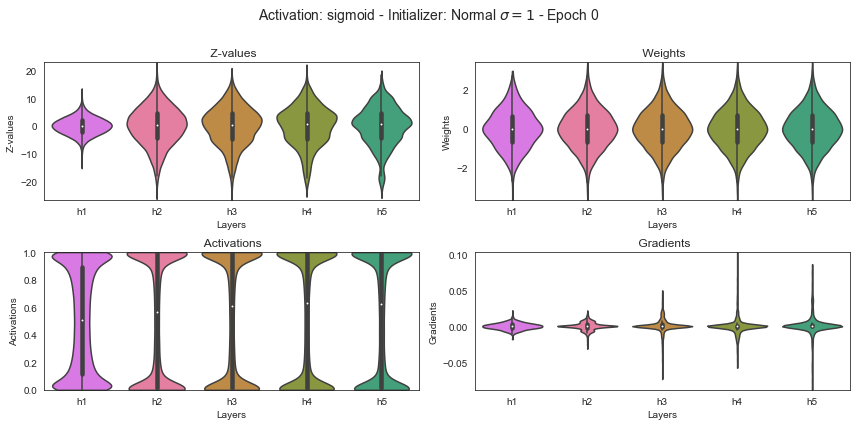

In [6]:
plot_violins(1, activation='sigmoid')

As demonstrated above, we observe that
- For a standard deviation of 0.01 and sigmoid activation, the gradients are pretty much non-existent (vanishing).
- For a standard deviation of 0.1 and sigmoid activation, the gradients improve a little, but still vanish as we approach the input layer.
- For a standard deviation of 1 and sigmoid activation, while we prevent the vanishing of gradients, the activations become extremely polarized, i.e., the Z-values are now pushed to the extremes, causing an abnormally binary-like activation output.

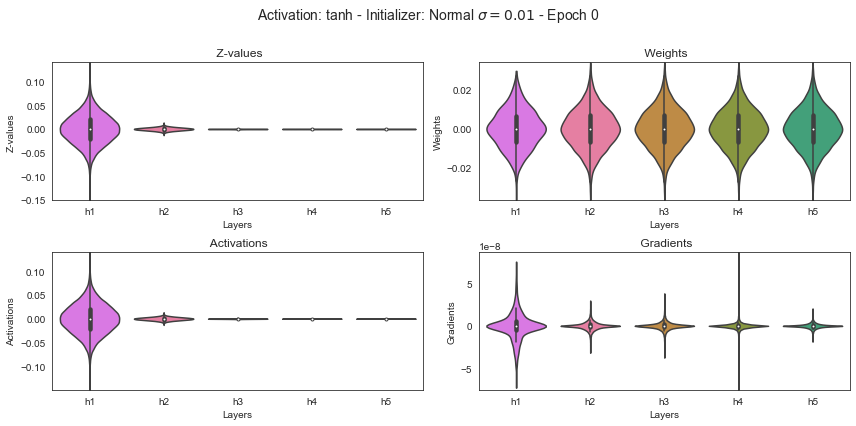

In [6]:
plot_violins(0.01, activation='tanh')

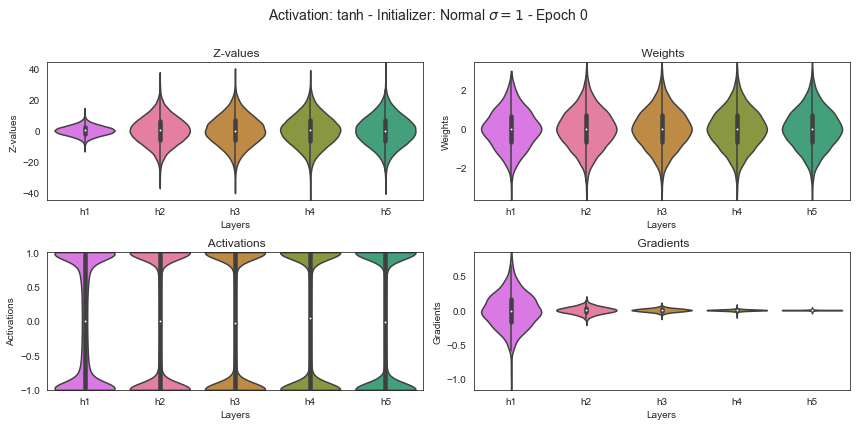

In [6]:
plot_violins(1, activation='tanh')

For the **tanh** activation, we observe the following:
- With a standard deviation of 0.01, we see marginally better gradients (though still negligible), but the Z-values and activations vanish almost completely
- With a standard deviation of 1, we see not only the same polarization of activations as before (for **sigmoid**), but also exploding gradients during backpropagation.

## Problem 3: Batch Norm, Dropout, MNIST

### 1.
#### Co-Adaptation
In Neural network, co-adaptation means that some neurons are highly dependent on others. Conseuquently, these co-dependent units seem to output correctly only under a very narrow and specific set of circumstances (inputs and features), causing them to frequently fire erroneously under general conditions. Co-adapted neurons have a high tendency for inaccurate results since even a single incorrect input to a unit can trigger a chain of incorrect outputs in all of its co-adapted peers. This behaviour is akin to overfitting, where the model performs great only on the training data (fixed specific circumstance), but fails to generalize and therefore performs poorly on validation/test data.

#### Internal Covariate Shift
We define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training. It's well known that a neural network trains faster the more consistent the distribution of the features are in any given layer. A shift in the distribution causes overhead due to the excess iterations required for the network to adjust to the new distributions. We can achieve convergence faster if we employ methods to counter internal covariate shift as it helps avoid this overhead.



### LeNet 5

In [155]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import  SubsetRandomSampler

In [16]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cpu')
print(device)

cpu


In [17]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor()]),
                                          download=True)


train_loader = DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [18]:
# Defining the convolutional neural network
def get_accuracy(pred_model, loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
#             images = images.to(device)
#             labels = labels.to(device)
            pred_model = pred_model.to("cpu")
            outputs = pred_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        pred_model.to(device)
        return 100 * correct / total
    

def get_mean_loss(pred_model, loader):
    tot_loss = 0
    for images, labels in loader:  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = pred_model(images)
        loss = cost(outputs, labels)
        tot_loss += loss
    
    return tot_loss / len(loader.dataset)
        
class LeNet5(nn.Module):
    def __init__(self, num_classes, input_tfs = [], hidden_tfs = []):
        super(LeNet5, self).__init__()
        
        # Input Layer
        self.conv1 =nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        input_tfs = [nn.Identity()] + input_tfs
        self.input_tfs = nn.Sequential(*input_tfs)
        self.layer1 = nn.Sequential(nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        # Hidden Layer
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        hidden_tfs = [nn.Identity()] + hidden_tfs
        self.hidden_tfs = nn.Sequential(*hidden_tfs)
        self.layer2 = nn.Sequential(nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.input_tfs(out)
        out = self.layer1(out)
        out = self.conv2(out)
        out = self.hidden_tfs(out)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### 2. Standard Norm on Input Layer, Batch Norm on Hidden Layer

In [19]:
model = LeNet5(num_classes, hidden_tfs = [nn.BatchNorm2d(16)]).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [20]:
total_step = len(train_loader)
std_tr_losses, std_ts_losses, std_tr_accuracy, std_ts_accuracy = [], [], [], []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        epoch_loss += loss * images.size(0)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    std_tr_accuracy.append(get_accuracy(model, train_loader))
    std_ts_accuracy.append(get_accuracy(model, test_loader))
    std_tr_losses.append(epoch_loss / len(train_loader.dataset))
    std_ts_losses.append(get_mean_loss(model, test_loader))

Epoch [1/10], Step [400/938], Loss: 0.0211
Epoch [1/10], Step [800/938], Loss: 0.0345
Epoch [2/10], Step [400/938], Loss: 0.0153
Epoch [2/10], Step [800/938], Loss: 0.0164
Epoch [3/10], Step [400/938], Loss: 0.0945
Epoch [3/10], Step [800/938], Loss: 0.0070
Epoch [4/10], Step [400/938], Loss: 0.1194
Epoch [4/10], Step [800/938], Loss: 0.0186
Epoch [5/10], Step [400/938], Loss: 0.0033
Epoch [5/10], Step [800/938], Loss: 0.0149
Epoch [6/10], Step [400/938], Loss: 0.0151
Epoch [6/10], Step [800/938], Loss: 0.0203
Epoch [7/10], Step [400/938], Loss: 0.0168
Epoch [7/10], Step [800/938], Loss: 0.1242
Epoch [8/10], Step [400/938], Loss: 0.0377
Epoch [8/10], Step [800/938], Loss: 0.0013
Epoch [9/10], Step [400/938], Loss: 0.0120
Epoch [9/10], Step [800/938], Loss: 0.0406
Epoch [10/10], Step [400/938], Loss: 0.0027
Epoch [10/10], Step [800/938], Loss: 0.0186


In [23]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Accuracy of the network on train images: {} %'.format(get_accuracy(model, train_loader)))

print('Accuracy of the network on test images: {} %'.format(get_accuracy(model, test_loader)))
	 

Accuracy of the network on train images: 99.775 %
Accuracy of the network on test images: 98.6 %


#### Input Layer Standard Normalized Parameters

In [24]:
print(f"Weights: {model.state_dict()['conv1.weight']}")
print(f"Bias: {model.state_dict()['conv1.bias']}")

Weights: tensor([[[[ 2.0148e-01, -7.3585e-03,  5.8398e-02, -2.0251e-01,  8.2223e-02],
          [ 1.1570e-01,  7.6834e-02, -1.5450e-01, -1.9265e-01, -1.0612e-01],
          [ 1.5244e-01, -1.9575e-02, -3.8467e-01, -1.3427e-01,  2.6949e-01],
          [ 1.2367e-01, -1.5880e-01, -2.4468e-01, -2.7817e-02,  1.1303e-01],
          [-1.2770e-01, -1.0910e-02, -2.3428e-01,  6.9124e-02,  1.3160e-01]]],


        [[[ 8.1516e-02,  3.4909e-02,  6.5704e-02,  5.8687e-02,  1.2924e-01],
          [-5.8671e-02, -1.4949e-01, -1.9976e-01,  8.2567e-02, -6.3626e-02],
          [ 1.8202e-01,  1.9853e-01, -2.2835e-01, -2.9550e-01, -1.7233e-01],
          [-3.5837e-02,  1.3635e-01,  1.5711e-01, -1.6940e-01, -1.4065e-01],
          [-1.4296e-01,  2.3171e-01,  2.2644e-01,  1.1162e-01,  4.4377e-02]]],


        [[[ 1.8385e-01,  1.0795e-01, -1.0316e-01,  3.5162e-04, -1.5337e-01],
          [-1.4807e-01, -1.4110e-01, -1.5816e-01, -3.0605e-02,  1.5162e-01],
          [-2.8757e-01, -1.4395e-01,  3.5887e-02,  1.6529e-

#### Hidden Later Batch Normalized Parameters

In [25]:
print(f"Weights: {model.state_dict()['hidden_tfs.1.weight']}")
print(f"Bias: {model.state_dict()['hidden_tfs.1.bias']}")

Weights: tensor([1.0312, 1.0669, 0.9772, 0.9933, 1.0543, 1.0002, 1.2115, 1.1934, 1.0527,
        1.1627, 1.0513, 1.0833, 0.9721, 1.1460, 1.1770, 1.2084])
Bias: tensor([-0.3647, -0.1501, -0.4467, -0.3547, -0.2325, -0.3418, -0.3203, -0.2756,
        -0.3812, -0.3900, -0.2446, -0.2167, -0.3848, -0.2317, -0.3255, -0.3228])


### 3. Batch Normalization on Input and Hidden Layer

In [26]:
model = LeNet5(num_classes, input_tfs = [nn.BatchNorm2d(6)], hidden_tfs = [nn.BatchNorm2d(16)]).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [27]:
total_step = len(train_loader)
bn_tr_losses, bn_ts_losses, bn_tr_accuracy, bn_ts_accuracy = [], [], [], []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        epoch_loss += loss * images.size(0)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    bn_tr_accuracy.append(get_accuracy(model, train_loader))
    bn_ts_accuracy.append(get_accuracy(model, test_loader))
    bn_tr_losses.append(epoch_loss / len(train_loader.dataset))
    bn_ts_losses.append(get_mean_loss(model, test_loader))

Epoch [1/10], Step [400/938], Loss: 0.0989
Epoch [1/10], Step [800/938], Loss: 0.0653
Epoch [2/10], Step [400/938], Loss: 0.0080
Epoch [2/10], Step [800/938], Loss: 0.0074
Epoch [3/10], Step [400/938], Loss: 0.0180
Epoch [3/10], Step [800/938], Loss: 0.0099
Epoch [4/10], Step [400/938], Loss: 0.0045
Epoch [4/10], Step [800/938], Loss: 0.0142
Epoch [5/10], Step [400/938], Loss: 0.0103
Epoch [5/10], Step [800/938], Loss: 0.0346
Epoch [6/10], Step [400/938], Loss: 0.0022
Epoch [6/10], Step [800/938], Loss: 0.0209
Epoch [7/10], Step [400/938], Loss: 0.0367
Epoch [7/10], Step [800/938], Loss: 0.0217
Epoch [8/10], Step [400/938], Loss: 0.0044
Epoch [8/10], Step [800/938], Loss: 0.0124
Epoch [9/10], Step [400/938], Loss: 0.0003
Epoch [9/10], Step [800/938], Loss: 0.0240
Epoch [10/10], Step [400/938], Loss: 0.0030
Epoch [10/10], Step [800/938], Loss: 0.0014


In [30]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Accuracy of the network on train images: {} %'.format(get_accuracy(model, train_loader)))

print('Accuracy of the network on test images: {} %'.format(get_accuracy(model, test_loader)))

Accuracy of the network on train images: 99.55166666666666 %
Accuracy of the network on test images: 99.0 %


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

w_input, w_hidden = model.state_dict()["input_tfs.1.weight"], model.state_dict()["hidden_tfs.1.weight"]
data = {"Input Layer": w_input.tolist(), "Hidden Layer": w_hidden.tolist()}

NameError: name 'model' is not defined

Input Layer Weights


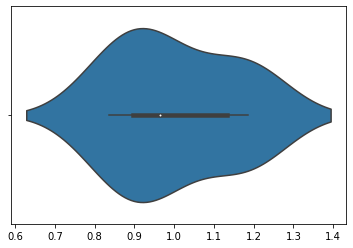

In [32]:
print("Input Layer Weights")
sns.violinplot(x="Input Layer", data=data)
plt.show()

Hidden Layer Weights


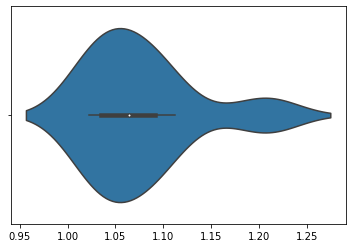

In [33]:
print("Hidden Layer Weights")
sns.violinplot(x="Hidden Layer", data=data)
plt.show()

In [ ]:
# Off load tensor
std_tr_losses = [x.cpu().detach() for x in std_tr_losses]
std_ts_losses = [x.cpu().detach() for x in std_ts_losses]
bn_tr_losses = [x.cpu().detach() for x in bn_tr_losses]
bn_ts_losses = [x.cpu().detach() for x in bn_ts_losses]

C:\Users\perfe\AppData\Local\Temp\ipykernel_21844\3805624258.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


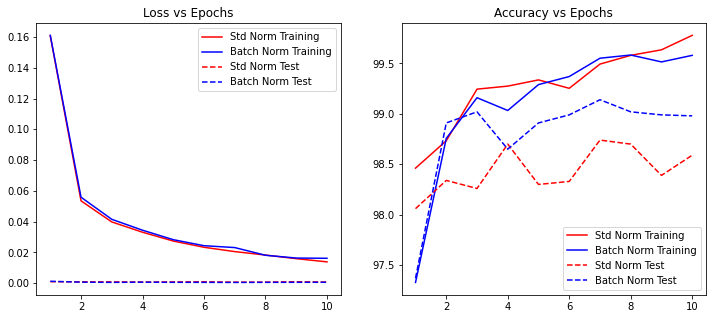

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot([i + 1 for i in range(num_epochs)], std_tr_losses, color="red", label="Std Norm Training", scaley=True, scalex=True)
axes[0].plot([i + 1 for i in range(num_epochs)], bn_tr_losses, color="blue", label="Batch Norm Training", scaley=True, scalex=True)
axes[0].plot([i + 1 for i in range(num_epochs)], std_ts_losses, "--", color="red", label="Std Norm Test", scaley=True, scalex=True)
axes[0].plot([i + 1 for i in range(num_epochs)], bn_ts_losses, "--", color="blue", label="Batch Norm Test", scaley=True, scalex=True)
axes[0].legend(loc="best")
axes[0].set_title("Loss vs Epochs")

axes[1].plot([i + 1 for i in range(num_epochs)], std_tr_accuracy, color="red", label="Std Norm Training")
axes[1].plot([i + 1 for i in range(num_epochs)], bn_tr_accuracy, color="blue", label="Batch Norm Training")
axes[1].plot([i + 1 for i in range(num_epochs)], std_ts_accuracy, "--", color="red", label="Std Norm Test")
axes[1].plot([i + 1 for i in range(num_epochs)], bn_ts_accuracy, "--", color="blue", label="Batch Norm Test")
axes[1].legend(loc="best")
axes[1].set_title("Accuracy vs Epochs")
fig.show()

## Problem 4 - Universal Approximators: Depth Vs. Width

In [8]:
from tqdm import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [125]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

# Utility Functions
def eggholder(x1, x2):
    return -(x2+47)*torch.sin(torch.sqrt(torch.abs((x1/2)+(x2+47)))) - x1*torch.sin(torch.sqrt(torch.abs(x1 - (x2 + 47))))

def generate_y(X):
    x1, x2 = X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1)
    return eggholder(x1, x2) + torch.normal(0, 0.3, size=(X.shape[0], 1))

Device being used: cuda


In [126]:
# Generate Data
n_rows, x_range = 10000, (-512, 512)
X = (x_range[0] - x_range[1]) * torch.rand(n_rows, 2) + x_range[1]
y = generate_y(X)

dataset = TensorDataset(X, y)

In [127]:
# Generate train, test datasets
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, lengths=[train_size, test_size])

In [160]:
# Models
class NN1(torch.nn.Module):

    def __init__(self, n_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 1)
        )
        
    def forward(self, x):
        return self.model(x)
    

class NN2(torch.nn.Module):

    def __init__(self, n_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, n_units[0]),
            nn.ReLU(),
            nn.BatchNorm1d(n_units[0]),
            nn.Linear(n_units[0], n_units[1]),
            nn.ReLU(),
            nn.BatchNorm1d(n_units[1]),
            nn.Linear(n_units[1], 1)
        )
        
    def forward(self, x):
        return self.model(x)


class NN3(nn.Module):
    def __init__(self, n_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, n_units[0]),
            nn.ReLU(),
            nn.BatchNorm1d(n_units[0]),
            nn.Linear(n_units[0], n_units[1]),
            nn.ReLU(),
            nn.BatchNorm1d(n_units[1]),
            nn.Linear(n_units[1], n_units[2]),
            nn.ReLU(),
            nn.BatchNorm1d(n_units[2]),
            nn.Linear(n_units[2], 1)
        )

    def forward(self, x):
        return self.model(x)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(net, train_ds, test_ds, batch_size=1000, learning_rate=2*(10**-7), epochs=10, debug=False):
    """Trains given dataset with specified hyperparameters to compute various metrics.
    
    Args:
        net: Neural Network class
        train_ds: Training dataset
        test_ds: Test dataset
        batch_size:
        learning_rate:
        epochs: Number of epochs to run.
        debug: Set debug messages with this

    Returns:
        Metrics such as train & test RMSE, runtime and number of trained parameters
    """
    net = net.to(device)
    
    trainloader = DataLoader(train_ds, batch_size=batch_size)
    testloader = DataLoader(test_ds, batch_size=batch_size)
    train_mse, test_mse = 0.0, 0.0
    l_train, l_test = len(train_ds), len(test_ds)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    criterion = nn.MSELoss()
    
    # Train the network
    start = datetime.now()
    with tqdm(range(epochs), unit="Epoch") as tepoch:
        for epoch in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            running_loss = 0.0
            for inputs, labels in trainloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                print(inputs.shape, outputs.shape, labels.shape)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

            tepoch.set_postfix(loss=running_loss)
    
    runtime = (datetime.now() - start).total_seconds() / 60  # runtime in minutes
    train_mse = running_loss / l_train
    
    # Test the network
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            prediction = net(inputs)
            loss = criterion(prediction, labels)
            test_mse += loss.item()
    
    test_mse /= l_test
    
    return train_mse, test_mse, count_parameters(net), runtime
            

def get_metrics_vs_netconfig(net_class, configs, learning_rate, epochs=2000):
    param_counts, losses, runtimes = [], [], []
    
    for config in configs:
        
        net = net_class(config)

        _, test_mse, n_params, runtime = train(net, train_set, test_set, learning_rate=learning_rate, epochs=epochs)
        losses.append(test_mse)
        param_counts.append(n_params)
        runtimes.append(runtime)
    
    return losses, param_counts, runtimes


def metric_map_to_mean_lists(metrics):
    metrics = [(k, sum(v) / len(v)) for k, v in metrics.items()]
    metrics = sorted(metrics, key=lambda x: x[0])
    x_val = [i for i, _ in metrics]
    y_val = [i for _, i in metrics]
    
    return x_val, y_val
    
def get_mean_metrics(config, losses, param_counts, runtimes):
    # Calculate mean loss for units
    unit_loss = {}
    for j, layers in enumerate(config[1]):
        n_units = sum(layers)
        val = unit_loss.get(n_units, [])
        val.append(losses[j])
        unit_loss[n_units] = val

    units, units_mean_losses = metric_map_to_mean_lists(unit_loss)
    
    # Calculate mean loss for params
    param_loss = {}
    for k, n_param in enumerate(param_counts):
        val = param_loss.get(n_param, [])
        val.append(losses[k])
        param_loss[n_param] = val

    param_counts, params_mean_loss = metric_map_to_mean_lists(param_loss)
    
    # Calculate mean runtime for params
    param_time = {}
    for k, n_param in enumerate(param_counts):
        val = param_time.get(n_param, [])
        val.append(runtimes[k])
        param_time[n_param] = val
    
    t_param_counts, param_mean_time = metric_map_to_mean_lists(param_time)
    
    return units, units_mean_losses, param_counts, params_mean_loss, t_param_counts, param_mean_time

### Q4.1

Epoch 2000: 100%|██████████| 2000/2000 [02:12<00:00, 15.14Epoch/s, loss=6.66e+5]


[92.369375, 90.32130859375, 87.2844140625, 86.66289453125, 87.1791796875, 86.85296484375]


Epoch 2000: 100%|██████████| 2000/2000 [02:28<00:00, 13.48Epoch/s, loss=4.7e+5] 


[94.8095390625, 91.85023046875, 89.65849609375, 87.42673828125, 83.67895703125, 79.80301953125, 71.93389453125, 65.441369140625]


Epoch 2000: 100%|██████████| 2000/2000 [02:31<00:00, 13.23Epoch/s, loss=1.02e+5]
C:\Users\perfe\AppData\Local\Temp\ipykernel_53684\1460923154.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[63.862396484375, 76.08951953125, 27.9375625, 32.5625166015625, 27.13263671875, 23.0945361328125, 23.9089560546875, 16.49953076171875, 15.0873837890625, 14.59965576171875]


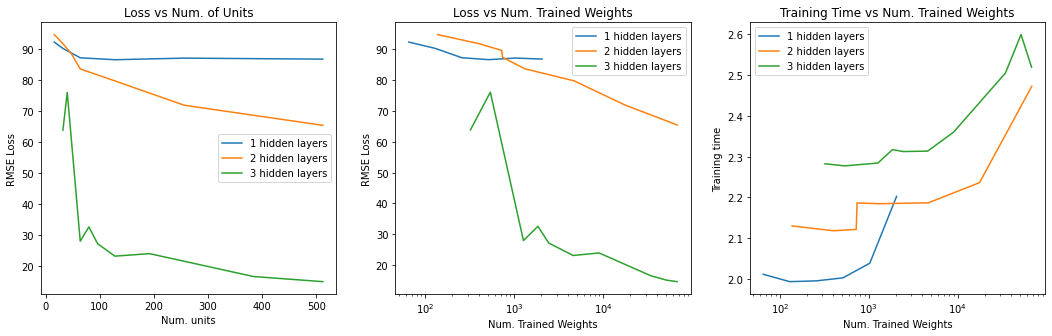

In [129]:
# Compute analysis metrics

# Network and layer configs to run
nn1_config = (NN1, [16, 32, 64, 128, 256, 512], 2*(10**-7))
nn2_config = (NN2, [[8, 8], [16, 16], [16, 32], [32, 16], [32, 32], [64, 64], [128, 128], [256, 256]], 10**-7)
nn3_config = (NN3, [[8, 8, 16], [8, 16, 16], [16, 32, 16], [16, 32, 32], [32, 32, 32], [32, 64, 32], [64, 64, 64], [128, 128, 128], [256, 128, 128], [128, 256, 128]], 10**-7)

net_config = [nn1_config, nn2_config, nn3_config]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, config in enumerate(net_config):
    start = datetime.now()
    losses, param_counts, runtimes = get_metrics_vs_netconfig(*config, epochs=2000)
    wall_clk_time = (datetime.now() - start).seconds
    units = config[1]
    
    # Average out metrics for configs with equal number of units
    if i > 0:
        (
            units,
            units_mean_losses,
            param_counts,
            params_mean_loss,
            t_param_counts,
            param_mean_time,
        ) = get_mean_metrics(config, losses, param_counts, runtimes)

    else:
        units_mean_losses = losses
        params_mean_loss = losses
        param_mean_time = runtimes
        t_param_counts = param_counts
        
        
    print(losses)
    
    # Plot graphs
    axes[0].plot(units, units_mean_losses, label=f"{i+1} hidden layers")
    axes[0].set_xlabel("Num. units")
    axes[0].set_ylabel("RMSE Loss")
    axes[0].legend(loc="best")
    axes[0].set_title("Loss vs Num. of Units")
    
    axes[1].plot(param_counts, params_mean_loss, label=f"{i+1} hidden layers")
    axes[1].set_xlabel("Num. Trained Weights")
    axes[1].set_ylabel("RMSE Loss")
    axes[1].legend(loc="best")
    axes[1].set_xscale("log")
    axes[1].set_title("Loss vs Num. Trained Weights")
    
    axes[2].plot(t_param_counts, param_mean_time, label=f"{i+1} hidden layers")
    axes[2].set_xlabel("Num. Trained Weights")
    axes[2].set_ylabel("Training time")
    axes[2].legend(loc="best")
    axes[2].set_xscale("log")
    axes[2].set_title("Training Time vs Num. Trained Weights")

fig.show()

### Q4.2
As shown above, the RMSE increases rapidly as we move from deeper to shallow networks for a given number of trained parameters. In fact, in almost all variations of hidden layer configurations, the deeper network outperforms the shallower one and converges significantly better.

The training time, however, follows the reverse trend as above. The training time decreases as for a given number of trained weights as we move from deepter to shallower network.

The overall conclusion is that while deeper network converge much better than shallower ones for the same number of units, they require a much greater training time than the alternative.

## Problem 5: Learning Rate, Batch Size, Fashion MNIST

In [262]:
# Load Data
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

#Preparing for validaion test
indices = list(range(len(train_set)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.8 * len(train_set)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(train_set, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(train_set, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [247]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120,10)
        #self.fc4 = nn.Linear(64,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        #not using dropout on output layer
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


### Q5.1

In [248]:
def train_fmnist_lrs(epochs):
    losses = []

    for lr in lr_candidates:
        model = Classifier().to(device)
        
        #defining the loss function
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        lr_candidates = [10**i for i in range(-9, 2)]

        train_losses, valid_losses = [],[]
        with tqdm(range(epochs), unit="Epoch") as tepoch:
            for epoch in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                running_loss = 0 

                # train the model #
                for images, labels in trainloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    log_ps = model(images)
                    loss = criterion(log_ps, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()*images.size(0)

                running_loss = running_loss/len(trainloader.sampler)
                tepoch.set_postfix(loss=running_loss)
                
        losses.append(running_loss)
    
    return losses

In [241]:
losses = train_fmnist_lrs(5)

Epoch 5: 100%|██████████| 5/5 [00:06<00:00,  1.20s/Epoch, loss=2.39]    


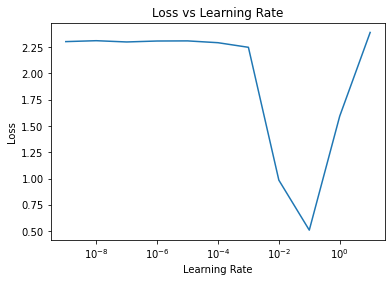

[(1e-09, 2.3019957110087077), (1e-08, 2.3107047901153566), (1e-07, 2.2986493377685546), (1e-06, 2.307664557774862), (1e-05, 2.3088302421569824), (0.0001, 2.2916187121073404), (0.001, 2.2478736324310304), (0.01, 0.984705282052358), (0.1, 0.5095486660798391), (1, 1.5933196957906086), (10, 2.3891688899993895)]


In [242]:
plt.plot(lr_candidates, losses)
plt.title("Loss vs Learning Rate")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

$lr_{min} = 10^{-3},\ lr_{max}=10^{-1}$

### Q5.2

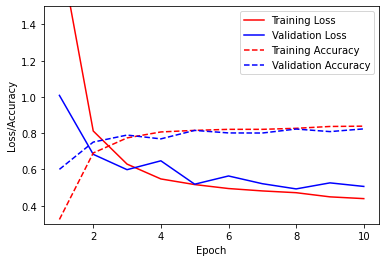

In [245]:
lr_min, lr_max, epochs = 10**-3, 0.1, 10

def train_fmnist_metrics(epochs):
    model = Classifier().to(device)
    #defining the loss function
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_min)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, mode="exp_range")

    train_losses, valid_losses, train_accuracy, valid_accuracy = [], [], [], []
    with tqdm(range(epochs), unit="Epoch") as tepoch:
        for epoch in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            running_loss = 0 
            valid_loss = 0
            train_correct = torch.Tensor([]).to(device)
            valid_correct = torch.Tensor([]).to(device)
            # train the model #
            for images, labels in trainloader:
                images = images.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                log_ps = model(images)
                _, pred = torch.max(log_ps, 1)
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()
                running_loss += loss.item()*images.size(0)
                train_correct = torch.cat((train_correct, (pred == labels)))

            for images, labels in validloader:
                images = images.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    log_ps = model(images)
                    _, pred = torch.max(log_ps, 1)
                    loss = criterion(log_ps, labels)
                    valid_loss += loss.item()*images.size(0)
                    valid_correct = torch.cat((valid_correct, (pred == labels)))
            
            train_accuracy.append(sum(train_correct) / train_correct.shape[0])
            valid_accuracy.append(sum(valid_correct) / valid_correct.shape[0])
            running_loss = running_loss/len(trainloader.sampler)
            valid_loss =  valid_loss/len(validloader.sampler)
            train_losses.append(running_loss)
            valid_losses.append(valid_loss)
            tepoch.set_postfix(loss=running_loss)
    
    train_accuracy = [i.cpu() for i in train_accuracy]
    valid_accuracy = [i.cpu() for i in valid_accuracy]
    
    return train_accuracy, valid_accuracy, train_losses, valid_losses
        
        
# train_accuracy, valid_accuracy, train_losses, valid_losses = train_fmnist_metrics(epochs)
plt.plot(range(1, epochs+1), train_losses, color="red", label="Training Loss")
plt.plot(range(1, epochs+1), valid_losses, color="blue", label="Validation Loss")
plt.plot(range(1, epochs+1), train_accuracy, "--", color="red", label="Training Accuracy")
plt.plot(range(1, epochs+1), valid_accuracy, "--", color="blue", label="Validation Accuracy")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylim(0.3, 1.5)
plt.ylabel("Loss/Accuracy")
plt.show()

### Q5.3

In [276]:
def train_fmnist_by_batch(epochs, batch_size):
    print(f"Training with batch size: {batch_size}")
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    
    model = Classifier().to(device)
    #defining the loss function
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_max)

    train_losses, test_losses = [], [], 
    with tqdm(range(epochs), unit="Epoch") as tepoch:
        for epoch in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            running_loss = 0 
            test_loss = 0
            count = 0
            
            # train the model #
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                log_ps = model(images)
                _, pred = torch.max(log_ps, 1)
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()*images.size(0)

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    log_ps = model(images)
                    _, pred = torch.max(log_ps, 1)
                    loss = criterion(log_ps, labels)
                    test_loss += loss.item()*images.size(0)
            
            
            running_loss = running_loss/len(train_loader.sampler)
            test_loss =  test_loss/len(test_loader.sampler)
            train_losses.append(running_loss)
            test_losses.append(test_loss)
            tepoch.set_postfix(loss=running_loss)
        
    return train_losses, test_losses

[32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]


Training with batch size: 32


Epoch 40: 100%|██████████| 40/40 [04:47<00:00,  7.18s/Epoch, loss=0.229]


Training with batch size: 64


Epoch 40: 100%|██████████| 40/40 [04:36<00:00,  6.92s/Epoch, loss=0.223]


Training with batch size: 128


Epoch 40: 100%|██████████| 40/40 [04:02<00:00,  6.05s/Epoch, loss=0.236]


Training with batch size: 256


Epoch 40: 100%|██████████| 40/40 [03:36<00:00,  5.40s/Epoch, loss=0.267]


Training with batch size: 512


Epoch 40: 100%|██████████| 40/40 [03:28<00:00,  5.21s/Epoch, loss=0.314]


Training with batch size: 1024


Epoch 40: 100%|██████████| 40/40 [03:22<00:00,  5.05s/Epoch, loss=0.368]


Training with batch size: 2048


Epoch 40: 100%|██████████| 40/40 [03:20<00:00,  5.01s/Epoch, loss=0.438]


Training with batch size: 4096


Epoch 40: 100%|██████████| 40/40 [03:22<00:00,  5.06s/Epoch, loss=0.524]


Training with batch size: 8192


Epoch 40: 100%|██████████| 40/40 [03:22<00:00,  5.07s/Epoch, loss=0.634]


Training with batch size: 16384


Epoch 40: 100%|██████████| 40/40 [03:23<00:00,  5.08s/Epoch, loss=0.812]
C:\Users\perfe\AppData\Local\Temp\ipykernel_53684\1908748482.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


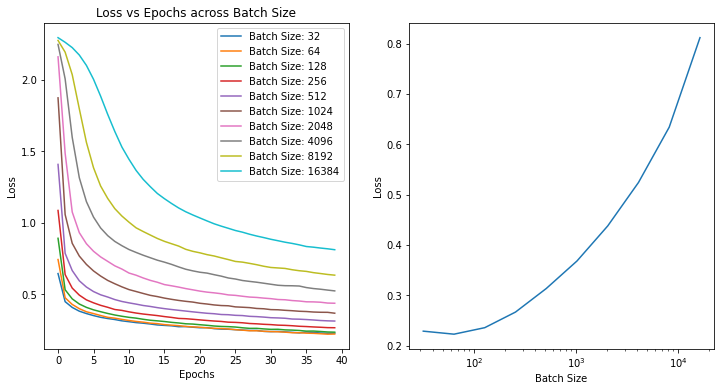

In [282]:
sizes = [2**i for i in range(5, 15)]
n_epochs = 40
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
size_losses = []

for size in sizes:
    train_losses, test_losses = train_fmnist_by_batch(n_epochs, size)
    axes[0].plot(range(n_epochs), train_losses, label=f"Batch Size: {size}")
    size_losses.append(train_losses[-1])  # log the final for the given batch size

axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="best")
axes[0].set_title("Loss vs Epochs across Batch Size")

axes[1].plot(sizes, size_losses)
axes[1].plot(sizes, )
axes[1].set_xscale("log")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Loss")
axes[1].set_title("Final Training/Validation Loss vs Batch Size")
fig.show()